In [2]:
# 1. Các thư viện cần thiết
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.varmax import VARMAX
from pmdarima.arima import auto_arima
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller

In [3]:
# 2. Đọc file dữ liệu chứng khoán Vietcombank và chia tập train test theo tỉ lệ 8:2
df = pd.read_csv('Vietcombank.csv')
df = df[['Close', 'High']]
df = df.dropna() # Drop missing values
df = df.reset_index(drop=True) # Reset the index

train_size = int(0.8 * len(df))
test_size = len(df) - train_size

train_data = df[:train_size]
test_data = df[train_size:]

In [4]:
# 3. Quá trình Training
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['Close'])

# Tìm mô hình ARIMA phù hợp nhất bằng auto_arima 
auto_arima(train_data['Close'], trace=True, error_action='ignore', suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=17539.864, Time=0.70 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=17535.653, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=17536.819, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=17536.809, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=17534.583, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=17538.790, Time=0.27 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.085 seconds


ARIMA(order=(0, 1, 0), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [5]:
model = VARMAX(train_data, order=(1, 1))
model_fit = model.fit(maxiter=1000, disp=False)

C:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'


In [6]:
# 4. Quá trình testing 
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Close'])
close_pred = model_fit.forecast(steps=len(y_test))
y_pred = close_pred['Close'].to_numpy()

In [7]:
# 5. Quá trình tạo index predict 90 ngày tiếp theo
last_index =  df.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+90, step=1)

# Tạo một mảng gồm 90 số nguyên liên tiếp bắt đầu từ last_index
x_next_90_days = np.array(range(last_index+1, last_index+91)).reshape(-1, 1)

# Dự đoán giá đóng cho 90 ngày tiếp theo
close_next_90_days = model_fit.forecast(steps=len(x_next_90_days))

y_next_90_days = close_next_90_days['Close'].to_numpy()

# In ra giá đóng đã được dự đoán trong 90 ngày tiếp theo
print('Predicted closing prices for the next 90 days:')
print(y_next_90_days)

Predicted closing prices for the next 90 days:
[74723.08890003 74657.86106644 74600.25112483 74546.77417071
 74495.57223228 74445.65462923 74396.49302069 74347.80553197
 74299.44167611 74251.32100748 74203.40041901 74155.65670895
 74108.07728737 74060.65522208 74013.38659761 73966.26910737
 73919.30130309 73872.48219478 73825.81103743 73779.28721729
 73732.91019129 73686.67945472 73640.59452397 73594.65492738
 73548.86020035 73503.20988265 73457.70351713 73412.3406489
 73367.12082496 73322.04359396 73277.10850611 73232.31511313
 73187.66296815 73143.15162576 73098.78064195 73054.54957411
 73010.45798104 72966.50542294 72922.69146138 72879.01565931
 72835.47758108 72792.0767924  72748.81286036 72705.68535339
 72662.69384131 72619.83789528 72577.11708781 72534.53099278
 72492.07918539 72449.76124219 72407.57674106 72365.52526122
 72323.6063832  72281.81968888 72240.16476143 72198.64118534
 72157.24854644 72115.98643183 72074.85442992 72033.85213043
 71992.97912436 71952.23500401 71911.61

In [8]:
# 6. Tính độ đo RMSE
test_rmse = np.sqrt(np.mean((y_pred - y_test)**2))
print('Testing RMSE:', test_rmse)

Testing RMSE: 19404.062589893318


In [9]:
# 7. Đánh giá độ chính xác thuật toán bằng MAPE
test_mape = np.mean(np.abs(y_pred - y_test)/np.abs(y_test))*100
print('Testing MAPE:', test_mape)

Testing MAPE: 20.483025251977686


In [10]:
# 8. Đánh giá độ chính xác thuật toán bằng MAE
test_mae = np.mean(abs(y_pred - y_test))
print('Testing MAE:', test_mae)

Testing MAE: 18300.772341011638


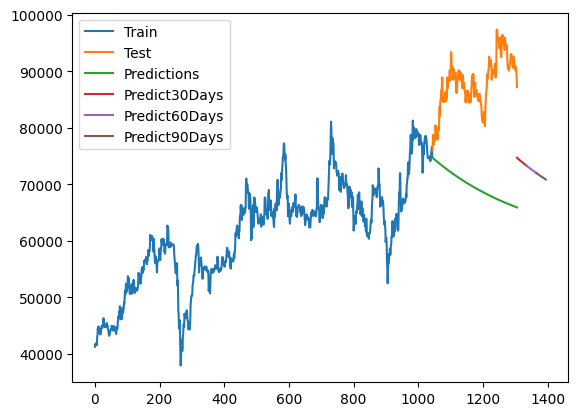

In [11]:
# 9.Vẽ hình
plt.plot(train_data.index, train_data['Close'])
plt.plot(test_data.index, test_data['Close'])
plt.plot(test_data.index, y_pred)
plt.plot(last_data[0:30],y_next_90_days[0:30])
plt.plot(last_data[30:60],y_next_90_days[30:60])
plt.plot(last_data[60:90],y_next_90_days[60:90])
plt.legend(['Train', 'Test', 'Predictions','Predict30Days', 'Predict60Days', 'Predict90Days'])
plt.show()

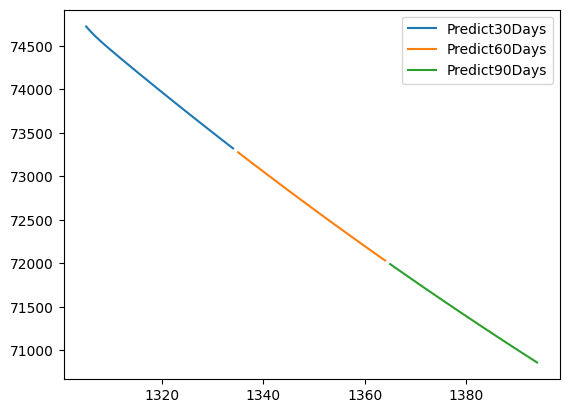

In [12]:
plt.plot(last_data[0:30],y_next_90_days[0:30])
plt.plot(last_data[30:60],y_next_90_days[30:60])
plt.plot(last_data[60:90],y_next_90_days[60:90])
plt.legend(['Predict30Days', 'Predict60Days', 'Predict90Days'])
plt.show()